<a href="https://colab.research.google.com/github/versant2612/jnotebooks/blob/main/Document_Similarities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from textblob import Word
import re
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from unicodedata import normalize


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
# https://lars76.github.io/2018/05/08/portuguese-lemmatizers.html#2
!pip install stanza
import stanza
stanza.download('pt')

     |████████████████████████████████| 432 kB 2.6 MB/s 
     |████████████████████████████████| 170 kB 61.2 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=26a1529570e404bceeefe8c7dd67c58fa36d7c3bfecb5e10690064f624931d0d
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


2021-11-04 14:21:49 INFO: Downloading default packages for language: pt (Portuguese)...


2021-11-04 14:21:58 INFO: Finished downloading models and saved to /root/stanza_resources.


In [3]:
# Sample corpus
documents_corpus = [
"meio ambiente desenvolvimento sustentável natureza socioambientais ética ambiental árvores asfalto drenagem natural de água filtragem reutilização \
dos recursos hídricos fontes naturais de energia eólica e solar gases produzidos reciclagem."
,
"Maria Celina Bodin de Moraes (Doutorado em direito civil, Università di Camerino, 1986) é Professora Titular de Direito Civil da Faculdade de \
Direito da Universidade do Estado do Rio de Janeiro (UERJ) e Professora Associada do Departamento de Direito da Pontifícia Universidade Católica do \
Rio de Janeiro (PUC-Rio). É ábitra e parecerista em Direito Privado e Editora-chefe da Civilistica.com - Revista Eletrônica de direito civil \
(Qualis A2). Foi diretora do Departamento de Direito da PUC-Rio e coordenadora da área do Direito da Faperj. Atua na área do direito privado, \
principalmente mediante a metodologia do direito civil constitucional. Os temas mais frequentes de sua produção científica são: princípios \
constitucionais da dignidade da pessoa humana e da solidariedade, aplicação direta da Constituição às relações privadas, proteção das pessoas \
vulneráveis, direitos da personalidade, relações familiares, contratos e responsabilidade civil."       
,
"Possui graduação em Engenharia Mecânica pela Pontifícia Universidade Católica do Rio de Janeiro (1982), mestrado em Engenharia de Produção - \
Departamento de Engenharia Industrial (1996) e doutorado em Engenharia de Produção pela Pontifícia Universidade Católica do Rio de Janeiro (2005). \
O mestrado e doutorado foram ambos na área de Finanças e Análise de Investimentos. Foi Consultor Master da Controladoria - Petróleo Brasileiro - \
Rio de Janeiro - Matriz, onde trabalhou de 01/02/1983 até 05/12/2016. É Professor Adjunto do Departamento de Engenharia Elétrica - PUC-Rio, sendo \
pesquisador do Grupo de Sistemas de Apoio à Decisão - Laboratório de Inteligência Computacional Aplicada. É autor de dois livros texto (pós-graduação) \
de opções reais. É Corporate Advisor do Real Options Group. Ministrou cursos de opções reais na Petrobras de 1996 a 2016, além de cursos de teoria \
dos jogos e valor da informação até 2016. Lá ministrou outros cursos como de análise de risco em projetos, finanças corporativas e project finance. \
Na PUC-Rio ministra curso de opções reais desde 2005 e de jogos de opções reais desde 2006. Coordenou vários projetos de pesquisa entre a Petrobras \
e universidades (principalmente PUC-Rio, mas também FGV e Mines Paris Tech). Já foi orador principal em várias conferências internacionais. Já deu \
seminários de opções reais em instituições internacionais (como o MIT em 2002 e 2003) e entidades nacionais (como a Unicamp em 1998, UFRJ em 2003 e \
a Alliance e Fundação Dom Cabral em 2005). Criou o primeiro website dedicado a opções reais (na PUC em 1995). Desenvolveu várias aplicações \
(inclusive software) de opções reais na Petrobras, onde também implantou padrões de análise de risco, de análise de investimento em informação e \
outros. Tem experiência na área de Engenharia de Produção, com ênfase em Avaliação Econômica de Projetos, atuando principalmente nos seguintes temas: \
opções reais, análise de investimentos sob incertezas, jogos de opções reais, teoria dos jogos, exploração e produção de petróleo, valor da informação, \
análise de risco em projetos, análise de investimento em energia renovável, custo de capital de projetos e financiamento corporativo."
,
"Doutora em Serviço Social (UERJ-2015). Mestre em Serviço Social (UFRJ -2010). Graduada em Serviço Social (UFRJ -1999). Possui experiência em \
diversas áreas do trabalho profissional do Serviço Social ( Empresa, AssistÊncia Social, Saúde, consultoria/assessoria). É docente e pesquisadora da \
Pontifícia Universidade Católica do Rio de Janeiro nos cursos de graduação e pós-graduação em Serviço Social, trabalhou em empresas multinacionais \
(Farmacêutica - GlaxoSmithKline e Telefonia celular- Claro), ONG (Obra Social do Rio de Janeiro), no setor público atuou na Prefeitura do Rio de \
Janeiro na condição de concursada. Autora do Livro Serviço Social e Consultoria Empresarial (2020), organizadora de coletâneas sobre trabalho, \
Serviço Social e Direitos Humanos."
,
"Engenheiro Mecânico formado pela Universidade Federal do Rio de Janeiro (1980), MSc em Engenharia Mecânica pela Pontifícia Universidade Católica \
do Rio de Janeiro (1988) e PhD em Engenharia Mecânica - Tecnologia de Aerossóis pela University of Minnesota (1994), USA. Professor Associado do \
Departamento de Engenharia Mecânica da Pontifícia Universidade Católica do Rio de Janeiro, onde coordena o grupo de pesquisas multidisciplinar de \
Engenharia Ambiental - Poluição Atmosférica atuando nos seguintes temas: tecnologia de aerossóis e instrumentação, processos atmosféricos, \
biocombustíveis, controle da poluição (poluentes locais e gases de efeito estufa), captura e armazenamento geológico de carbono, desenvolvimento de \
sensores ambientais, e geração de energia através de resíduos sólidos urbanos (Waste to Energy, WTE). Engenheiro de Petróleo pela Petrobras (CEPET 81), \
onde atuou entre 1981-1985. Membro do IPCC - Intergovernmental Panel on Climate Change (entre 2004-2017), grupo de cientistas que recebeu o Prêmio Nobel\
 da Paz em 2007."
,
"Flávia de Almeida Viveiros de Castro é Juíza de Direito e Professora Convidada da EMERJ (Escola da Magistratura do Estado do Rio de Janeiro) ESAJ \
(Escola de Administração Judiciária do Tribunal de Justiça do Estado do Rio de Janeiro) e Fundação Getúlio Vargas - RJ; Possui Pós-Doutorado em \
Direitos Humanos pelo Instituto JUS GENTIUM da Faculdade de Direito de Coimbra (2017/18). É doutora em Direito o Civil-Constitucional pela Universidade \
de Direito do Estado do Rio de Janeiro(2006). Mestre em Direito pela Pontifícia Universidade Católica do Rio de Janeiro (1999); Mestre em Ciência \
Política (Ciência Política e Sociologia) pela Pontifícia Universidade Católica do Rio de Janeiro (1990); Possui curso de Especialização em direito \
português pelo Centro de Estudos Judiciários de Portugal (1997) e Especialização em Ciência Política, pelo Instituto Metodista Bennett (1985); Graduada \
em Direito e em Comunicação Social, especialidade Jornalismo pela Pontifícia Universidade Católica do Rio de Janeiro (1980 e 1990). É Juíza Titular da \
6ª Vara Cível Regional da Barra da Tijuca, tendo exercido a magistratura em varas de falência, fazenda pública, criminal, tribunal do júri, orfãos e \
sucessões e família. Já assumiu a função de Juíza Eleitoral na 175 Zona Eleitoral. Já exerceu a mesma função em Marechal Hermes, Bangu e Pavuna. Foi \
Juíza Corregedora - Auxiliar da Corregedora de Justiça em (1996);Exerce a docência como palestrante e professora convidada nas áreas de Direito Civil \
e Direito Tributário. Foi coordenadora acadêmica do Instituto de direito da Pontifícia Universidade Católica do Rio de Janeiro e coordenadora acadêmica \
dos cursos de pós-graduação em direito imobiliário, direito fiscal, direito empresarial, direito processual civil e direito da saúde do Instituto de \
Direito da PUC-RJ."
,
"Vitor Nascimento Aguiar graduou-se em Engenharia Civil com ênfase em Mecânica dos Solos na Universidade Federal do Rio de Janeiro (UFRJ) em 2006. \
Concluiu o mestrado e o doutorado em Engenharia Civil (Geotecnia) pela COPPE/UFRJ em 2008 e 2014. Em suas pesquisas de mestrado e doutorado, investigou \
efeitos de tempo e de velocidade de deformação no adensamento e na resistência ao cisalhamento de argilas moles saturadas. Atuou por dez anos em \
projetos e consultorias de obras de infraestrutura na Mecasolo Engenharia e Consultoria. Realizou estágio de pós-doutorado no Norwegian Geotechnical \
Institute (NGI) de 2017 a 2018. Atualmente é professor do quadro principal do Departamento de Engenharia Civil e Ambiental da Pontifícia Universidade \
Católica do Rio de Janeiro (PUC-Rio), onde leciona a disciplina de Laboratório de Geotecnia na graduação e as disciplinas de Ensaios de Laboratório e \
Geotecnia Experimental na pós-graduação. Tem exercido o cargo de secretário executivo na Associação Brasileira de Mecânica dos Solos - Núcleo RJ."
]

In [4]:
# lemmatization for portuguese

stnz = stanza.Pipeline('pt', use_gpu=False)

# lemmas_df=pd.DataFrame(stnz(documents),columns=['documents'])

# doc = stnz(documents_df['documents'][0])
# for sent in doc.sentences: 
#  for word in sent.words:
#    print(word.lemma)

length = len(documents_corpus)
documents_stnz = []
documents = []
for i in range(length):
  documents_stnz.append(stnz(documents_corpus[i]))
  documents.append('')
  for sent in documents_stnz[i].sentences: 
    for word in sent.words:
      documents[i] = documents[i] + " " + word.lemma

# documents_df['documents']=documents_df['documents'].apply(lambda x: " ".join(word.lemma for sent in stnz(documents_df).sentences for word in sent.words))

# documents_df['documents'].apply(lambda x: " ".join(str(word.lemma for sent in stnz(x).sentences for word in sent.words) for x in x.split()))

2021-11-04 14:21:59 INFO: Loading these models for language: pt (Portuguese):
| Processor | Package |
-----------------------
| tokenize  | bosque  |
| mwt       | bosque  |
| pos       | bosque  |
| lemma     | bosque  |
| depparse  | bosque  |

2021-11-04 14:21:59 INFO: Use device: cpu
2021-11-04 14:21:59 INFO: Loading: tokenize
2021-11-04 14:21:59 INFO: Loading: mwt
2021-11-04 14:21:59 INFO: Loading: pos
2021-11-04 14:21:59 INFO: Loading: lemma
2021-11-04 14:21:59 INFO: Loading: depparse
2021-11-04 14:22:00 INFO: Done loading processors!
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at 

In [5]:
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', 0)

In [6]:
documents_df=pd.DataFrame(documents,columns=['documents'])

### Corpus Dataframe

In [7]:
documents_df

,documents
0,meio ambiente desenvolvimento sustentável natureza socioambiental ético ambiental árvore asfalto drenagem natural de água filtragem reutilização de o recurso hídrico fonte natural de energia eólico e solar gase produzir reciclagem .
1,"Maria Celina Bodin de Moraes ( Doutorado em direito civil , Università di Camerino , 1986 ) ser Professora Titular de Direito Civil de o Faculdade de Direito de o Universidade de o Estado de o Rio de Janeiro ( UERJ ) e Professora Associada de o Departamento de Direito de o Pontifícia Universidade Católica de o Rio de Janeiro ( PUC-Rio ) . ser ábitro e parecerista em Direito Privado e Editora-chefe de o Civilistica . com - revista Eletrônica de direito civil ( Qualis A2 ) . ser diretora de o Departamento de Direito de o PUC-Rio e coordenadora de o área de o Direito de o Faperj . atuar em o área de o direito privado , principalmente mediante o metodologia de o direito civil constitucional . o tema mais frequente de seu produção científico ser : princípio constitucional de o dignidade de o pessoa humano e de o solidariedade , aplicação direto de o constituição a o relação privado , proteção de o pessoa vulnerável , direito de o personalidade , relação familiar , contrato e responsabilidade civil ."
2,"possuir graduação em Engenharia Mecânica por o Pontifícia Universidade Católica de o Rio de Janeiro ( 1982 ) , mestrado em Engenharia de Produção - Departamento de Engenharia Industrial ( 1996 ) e doutorado em Engenharia de Produção por o Pontifícia Universidade Católica de o Rio de Janeiro ( 2005 ) . o mestrado e doutorado ser ambos em o área de Finanças e Análise de Investimentos . ser Consultor Master de o Controladoria - Petróleo Brasileiro - Rio de Janeiro - Matriz , onde trabalhar de 01/02/1983 até 05/12/2016 . ser Professor Adjunto de o Departamento de Engenharia Elétrica - PUC-Rio , ser pesquisador de o Grupo de Sistemas de Apoio a o decisão - Laboratório de Inteligência Computacional aplicar . ser autor de dois livro texto ( pós-graduação ) de opção real . ser Corporate Advisor de o Real Options Group . ministrar curso de opção real em o Petrobras de 1996 a 2016 , além de curso de teoria de o jogo e valor de o informação até 2016 . lá ministrar outro curso como de análise de risco em projeto , finanças corporativo e project finance . em o PUC-Rio ministra curso de opção real desde 2005 e de jogo de opção real desde 2006 . coordenar vários projeto de pesquisa entre o Petrobras e universidade ( principalmente PUC-Rio , mas também FGV e Mines Paris Tech ) . já ser orador principal em várias conferência internacional . já dar seminário de opção real em instituição internacional ( como o MIT em 2002 e 2003 ) e entidade nacional ( como o Unicamp em 1998 , UFRJ em 2003 e o Alliance e Fundação Dom Cabral em 2005 ) . criar o primeiro website dedicar a opção real ( em o PUC em 1995 ) . desenvolver várias aplicação ( inclusive software ) de opção real em o Petrobras , onde também implantar padrão de análise de risco , de análise de investimento em informação e outro . ter experiência em o área de Engenharia de Produção , com ênfase em Avaliação Econômica de Projetos , atuar principalmente em o seguinte tema : opção real , análise de investimento sob incerteza , jogo de opção real , teoria de o jogo , exploração e produção de petróleo , valor de o informação , análise de risco em projeto , análise de investimento em energia renovável , custo de capital de projeto e financiamento corporativo ."
3,"doutora em Serviço Social ( UERJ-2015 ) . mestre em Serviço Social ( UFRJ -2010 ) . graduar em Serviço Social ( UFRJ -1999 ) . possuir experiência em diversos área de o trabalho profissional de o Serviço Social ( Empresa , AssistÊncia Social , Saúde , consultoria / assessoria ) . ser docente e pesquisadora de o Pontifícia Universidade Católica de o Rio de Janeiro em o curso de graduação e pós-graduação em Serviço Social , trabalhar em empresa multinacional ( Farmacêutica - GlaxoSmithKline e Telefoni

In [8]:
# removing special characters and stop words from the text
stop = stopwords.words('portuguese')
# stop.extend(['puc-rio', 'puc', 'rio', 'janeiro', 'pontificia', 'universidade', 'catolica'])
documents_df['documents']=documents_df['documents'].apply(lambda x: " ".join(normalize('NFD', x).encode('ascii', 'ignore').decode("utf-8").lower() for x in x.split() if x not in stop ))
documents_df['documents'] = documents_df['documents'].apply(lambda x: " ".join(re.sub('[^a-zA-Z \n]', ' ', x).lower() for x in x.split()))
# documents_df['documents'] = documents_df['documents'].apply(lambda x: " ".join(Word(x).lemmatize() for x in x.split() if x not in stop))

In [9]:
documents_df

,documents
0,meio ambiente desenvolvimento sustentavel natureza socioambiental etico ambiental arvore asfalto drenagem natural agua filtragem reutilizacao recurso hidrico fonte natural energia eolico solar gase produzir reciclagem
1,maria celina bodin moraes doutorado direito civil universita di camerino ser professora titular direito civil faculdade direito universidade estado rio janeiro uerj professora associada departamento direito pontificia universidade catolica rio janeiro puc rio ser abitro parecerista direito privado editora chefe civilistica revista eletronica direito civil qualis a ser diretora departamento direito puc rio coordenadora area direito faperj atuar area direito privado principalmente mediante metodologia direito civil constitucional tema frequente producao cientifico ser principio constitucional dignidade pessoa humano solidariedade aplicacao direto constituicao relacao privado protecao pessoa vulneravel direito personalidade relacao familiar contrato responsabilidade civil
2,possuir graduacao engenharia mecanica pontificia universidade catolica rio janeiro mestrado engenharia producao departamento engenharia industrial doutorado engenharia producao pontificia universidade catolica rio janeiro mestrado doutorado ser ambos area financas analise investimentos ser consultor master controladoria petroleo brasileiro rio janeiro matriz onde trabalhar ser professor adjunto departamento engenharia eletrica puc rio ser pesquisador grupo sistemas apoio decisao laboratorio inteligencia computacional aplicar ser autor dois livro texto pos graduacao opcao real ser corporate advisor real options group ministrar curso opcao real petrobras alem curso teoria jogo valor informacao la ministrar outro curso analise risco projeto financas corporativo project finance puc rio ministra curso opcao real desde jogo opcao real desde coordenar varios projeto pesquisa petrobras universidade principalmente puc rio fgv mines paris tech ser orador principal varias conferencia internacional dar seminario opcao real instituicao internacional mit entidade nacional unicamp ufrj alliance fundacao dom cabral criar primeiro website dedicar opcao real puc desenvolver varias aplicacao inclusive software opcao real petrobras onde implantar padrao analise risco analise investimento informacao outro ter experiencia area engenharia producao enfase avaliacao economica projetos atuar principalmente seguinte tema opcao real analise investimento sob incerteza jogo opcao real teoria jogo exploracao producao petroleo valor informacao analise risco projeto analise investimento energia renovavel custo capital projeto financiamento corporativo
3,doutora servico social uerj mestre servico social ufrj graduar servico social ufrj possuir experiencia diversos area trabalho profissional servico social empresa assistencia social saude consultoria assessoria ser docente pesquisadora pontificia universidade catolica rio janeiro curso graduacao pos graduacao servico social trabalhar empresa multinacional farmaceutica glaxosmithkline telefonia celular claro ong obra social rio janeiro setor publico atuar prefeitura rio janeiro condicao concursar autora livro servico social consultoria empresarial organizadora coletanea sobre trabalho servico social direitos humanos
4,engenheiro mecanico formar universidade federal rio janeiro msc engenharia mecanica pontificia universidade catolica rio janeiro phd engenharia mecanica tecnologia aerossois university of minnesota usa professor associado departamento engenharia mecanica pontificia universidade catolica rio janeiro onde coordenar grupo pesquisa multidisciplinar engenharia ambiental poluicao atmosferica atuar seguinte tema tecnologia aerossol instrumentacao processo atmosferico biocombustivel controle poluicao poluente local gase efeito estufo captura armazenamento geologico carbono desenvolvimento sensor ambiental geracao energia atraves residuo solido urbano waste to energy wte engenheiro petroleo petrobras cepet onde 

#### Tf-idf vectors

**Embeddings**

são as representações vetoriais de texto em que palavras ou sentenças com significado ou contexto semelhantes têm representações semelhantes.

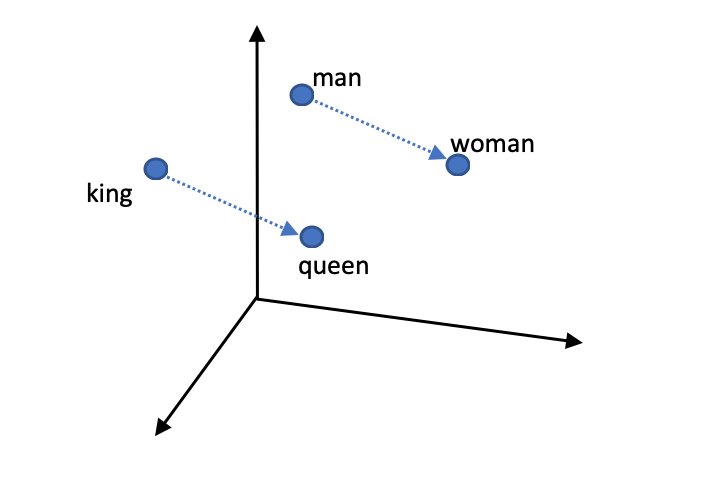

**Tf-idf** é uma combinação de frequência de termo e frequência inversa de documento. Ele atribui um peso a cada palavra no documento, que é calculado usando a frequência dessa palavra no documento e a frequência dos documentos com essa palavra em todo o corpus de documentos.

TfidfVectorizer: Convert a collection of raw documents to a matrix of TF-IDF features. Equivalent to CountVectorizer followed by TfidfTransformer.

In [10]:
tfidfvectoriser=TfidfVectorizer(max_features=128)
tfidfvectoriser.fit(documents_df['documents'])
tfidf_vectors=tfidfvectoriser.transform(documents_df['documents'])

In [11]:
tfidf_vectors.shape

(7, 128)

In [12]:
# Every vector is already normalised to have unit L2 norm
np.linalg.norm(tfidf_vectors.toarray()[0],ord=2)

1.0

In [13]:
tfidf_vectors=tfidf_vectors.toarray()
print (tfidf_vectors[0])

[0.         0.26109401 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.3054564  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.26109401
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.3054564  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.73596337 0.36798169 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

##### Every document has been converted into a 64 dimensional vector. As we set the max_features=64

### Pairwise similarity

##### Pairwise cosine similarity would just be the dot product of the vectors becasue tf-idf vectors from sklearn are already normalized and L2 norm of these vectors is 1. So denominator of cosine similiarity formula is 1 in this case.

In [14]:
pairwise_similarities=np.dot(tfidf_vectors,tfidf_vectors.T)
pairwise_differences=euclidean_distances(tfidf_vectors)

In [15]:
print (tfidf_vectors[0])
print (pairwise_similarities.shape)
print (pairwise_similarities[0][:])

[0.         0.26109401 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.3054564  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.26109401
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.3054564  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.73596337 0.36798169 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

##### similarity is highest, 1 at index 0 becasue they are the same documents

In [16]:
def most_similar(doc_id,similarity_matrix,matrix):
    print (f'Document: {documents_df.iloc[doc_id]["documents"]}')
    print (f'Similar Documents using {matrix}:')
    if matrix=='Cosine Similarity':
        similar_ix=np.argsort(similarity_matrix[doc_id])[::-1]
    elif matrix=='Euclidean Distance':
        similar_ix=np.argsort(similarity_matrix[doc_id])
    for ix in similar_ix:
        if ix==doc_id:
            continue
        print('Id:', ix, '... ', end="")
#        print (f'Document: {documents_df.iloc[ix]["documents"]}')
        print (f'{matrix} : {similarity_matrix[doc_id][ix]}')

**Similaridade do cosseno** - É o cosseno do ângulo entre dois vetores, que nos dá a distância angular entre os vetores. A fórmula para calcular a similaridade de cosseno entre dois vetores A e B é,

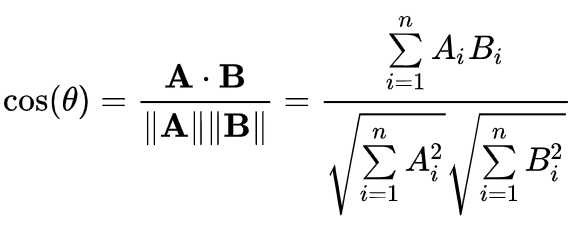

**Distância Euclidiana**

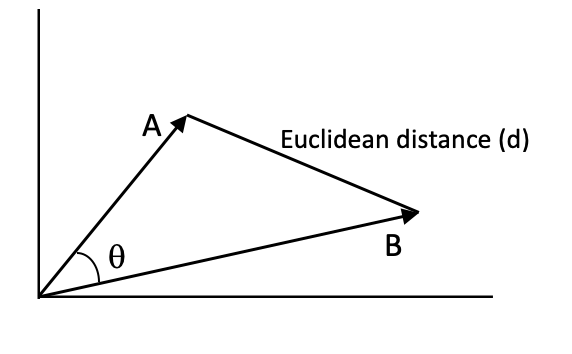

In [17]:
most_similar(0,pairwise_similarities,'Cosine Similarity')

Document: meio ambiente desenvolvimento sustentavel natureza socioambiental etico ambiental arvore asfalto drenagem natural agua filtragem reutilizacao recurso hidrico fonte natural energia eolico solar gase produzir reciclagem  
Similar Documents using Cosine Similarity:
Id: 4 ... Cosine Similarity : 0.1455344884543932
Id: 6 ... Cosine Similarity : 0.022718259353533755
Id: 2 ... Cosine Similarity : 0.00894008178769479
Id: 5 ... Cosine Similarity : 0.0
Id: 3 ... Cosine Similarity : 0.0
Id: 1 ... Cosine Similarity : 0.0


In [18]:
most_similar(0,pairwise_differences,'Euclidean Distance')

Document: meio ambiente desenvolvimento sustentavel natureza socioambiental etico ambiental arvore asfalto drenagem natural agua filtragem reutilizacao recurso hidrico fonte natural energia eolico solar gase produzir reciclagem  
Similar Documents using Euclidean Distance:
Id: 4 ... Euclidean Distance : 1.3072608856273538
Id: 6 ... Euclidean Distance : 1.3980570379254675
Id: 2 ... Euclidean Distance : 1.407877777516433
Id: 3 ... Euclidean Distance : 1.4142135623730947
Id: 1 ... Euclidean Distance : 1.414213562373095
Id: 5 ... Euclidean Distance : 1.4142135623730951


#### word2vec embeddings

In [19]:
from keras.preprocessing.text import Tokenizer
import gensim
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:
# tokenize and pad every document to make them of the same size
tokenizer=Tokenizer()
tokenizer.fit_on_texts(documents_df['documents'])
tokenized_documents=tokenizer.texts_to_sequences(documents_df['documents'])
tokenized_paded_documents=pad_sequences(tokenized_documents,maxlen=128,padding='post')
vocab_size=len(tokenizer.word_index)+1

print (tokenized_paded_documents[0])

[113 114  60 115 116 117 118  28 119 120 121  61 122 123 124 125 126 127
  61  39 128 129  62 130 131   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


We can train our own embeddings if have enough data and computation available or we can use pre-trained embeddings. We will use pre-trained embeddings (Word2Vec and GloVe 300) provided by NILC.

http://www.nilc.icmc.usp.br/embeddings

In [21]:
# loading pre-trained embeddings, each word is represented as a 300 dimensional vector
import gensim
# W2V_PATH="https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
# model_w2v = gensim.models.KeyedVectors.load_word2vec_format(W2V_PATH, binary=True)

!wget "http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s300.zip"
!unzip *skip_s300.zip


--2021-11-04 14:22:11--  http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s300.zip
Connecting to 143.107.183.175:22980... connected.
HTTP request sent, awaiting response... 200 OK
Length: 958619745 (914M) [application/octet-stream]
Saving to: ‘download.php?file=embeddings%2Fword2vec%2Fskip_s300.zip’

download.php?file=e 100%[===================>] 914.21M  11.2MB/s    in 92s     

2021-11-04 14:23:43 (9.94 MB/s) - ‘download.php?file=embeddings%2Fword2vec%2Fskip_s300.zip’ saved [958619745/958619745]

Archive:  download.php?file=embeddings%2Fword2vec%2Fskip_s300.zip
  inflating: skip_s300.txt           


In [22]:
from gensim.models import KeyedVectors
model_w2v = KeyedVectors.load_word2vec_format('skip_s300.txt')

In [23]:
# creating embedding matrix, every row is a vector representation from the vocabulary indexed by the tokenizer index. 
embedding_matrix=np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
    if word in model_w2v:
        embedding_matrix[i]=model_w2v[word]

In [24]:
embedding_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [25]:
embedding_matrix[tokenizer.word_index['sustentavel']]

array([ 6.52000010e-02,  5.16929999e-02,  2.11859997e-02,  4.70659994e-02,
        8.09770003e-02,  7.90050030e-02, -1.16402999e-01, -1.36920005e-01,
        3.48940007e-02,  1.49320001e-02,  1.15750998e-01,  8.41649994e-02,
        1.80700002e-03,  9.49579999e-02, -2.36489996e-02,  2.02776000e-01,
       -6.20630011e-02, -2.99110003e-02,  1.13460002e-02,  4.74819988e-02,
        1.95152998e-01,  1.02639999e-02,  8.94199982e-02, -7.71979988e-02,
       -6.19399995e-02,  2.36450005e-02, -6.09840006e-02,  1.04480004e-02,
        1.02415003e-01,  5.11710010e-02, -2.09180005e-02, -3.96840014e-02,
        1.42610997e-01,  1.98209994e-02, -5.85349984e-02,  2.92339996e-02,
        1.64609998e-02,  2.39499994e-02, -2.70809997e-02, -1.33564994e-01,
        4.13869992e-02, -1.08425997e-01,  5.00690006e-02,  1.87171996e-01,
        1.20569997e-01,  1.04700001e-02,  1.24062002e-01,  3.34019996e-02,
        1.35399997e-02, -1.42495006e-01,  1.17574997e-01,  4.55660000e-02,
        2.20094994e-01,  

In [26]:
# creating document-word embeddings
document_word_embeddings=np.zeros((len(tokenized_paded_documents),128,300))

for i in range(len(tokenized_paded_documents)):
    for j in range(len(tokenized_paded_documents[0])):
        document_word_embeddings[i][j]=embedding_matrix[tokenized_paded_documents[i][j]]

In [27]:
document_word_embeddings.shape

(7, 128, 300)

Now we have to represent every document as a single vector. We can either average or sum over every word vector and convert every 64X300 representation into a 300-dimensional representation. But averaging or summing over all the words would lose the semantic and contextual meaning of the documents. Different lengths of the documents would also have an adverse effect on such operations.

One better way of doing this could be taking a weighted average of word vectors using the tf-idf weights. This can handle the variable length problem to a certain extent but cannot keep the semantic and contextual meaning of words. After doing that we can use the pairwise distances to calculate similar documents as we did in the tf-idf model.

In [28]:
# tf-idf vectors do not keep the original sequence of words, converting them into actual word sequences from the documents

document_embeddings=np.zeros((len(tokenized_paded_documents),300))
words=tfidfvectoriser.get_feature_names()

for i in range(len(document_word_embeddings)):
    for j in range(len(words)):
        document_embeddings[i]+=embedding_matrix[tokenizer.word_index[words[j]]]*tfidf_vectors[i][j]
        
document_embeddings=document_embeddings/np.sum(tfidf_vectors,axis=1).reshape(-1,1)
    

In [29]:
pairwise_similarities=cosine_similarity(document_embeddings)
pairwise_differences=euclidean_distances(document_embeddings)

In [30]:
most_similar(0,pairwise_similarities,'Cosine Similarity')

Document: meio ambiente desenvolvimento sustentavel natureza socioambiental etico ambiental arvore asfalto drenagem natural agua filtragem reutilizacao recurso hidrico fonte natural energia eolico solar gase produzir reciclagem  
Similar Documents using Cosine Similarity:
Id: 2 ... Cosine Similarity : 0.44131498565982613
Id: 4 ... Cosine Similarity : 0.4081641287946105
Id: 6 ... Cosine Similarity : 0.3785309886250442
Id: 3 ... Cosine Similarity : 0.3553731961823813
Id: 1 ... Cosine Similarity : 0.27178458607903233
Id: 5 ... Cosine Similarity : 0.26827768544591957


In [31]:
most_similar(0,pairwise_differences,'Euclidean Distance')

Document: meio ambiente desenvolvimento sustentavel natureza socioambiental etico ambiental arvore asfalto drenagem natural agua filtragem reutilizacao recurso hidrico fonte natural energia eolico solar gase produzir reciclagem  
Similar Documents using Euclidean Distance:
Id: 2 ... Euclidean Distance : 1.4990520845268887
Id: 4 ... Euclidean Distance : 1.6028633450992862
Id: 3 ... Euclidean Distance : 1.6945406371430412
Id: 6 ... Euclidean Distance : 1.755560801523878
Id: 5 ... Euclidean Distance : 1.8060854072131798
Id: 1 ... Euclidean Distance : 1.8733028499345212


#### Glove embeddings

Global Vectors for word Embedding (GloVe) is an unsupervised learning algorithm to produce vector representations of word. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

We will use the pre-trained Glove embeddings. All the steps would remain same as word2vec embeddings it’s just that in this case we will use the Glove pre-trained model. We are using Glove embeddings of 300-dimensions because of the large size of the embeddings file. You can use higher dimensions also

In [ ]:
# reading Glove word embeddings into a dictionary with "word" as key and values as word vectors

!wget http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s300.zip
!unzip *glove*.zip


--2021-11-04 14:29:08--  http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s300.zip
Connecting to 143.107.183.175:22980... connected.
HTTP request sent, awaiting response... 200 OK
Length: 993190150 (947M) [application/octet-stream]
Saving to: ‘download.php?file=embeddings%2Fglove%2Fglove_s300.zip’

.zip                 46%[========>           ] 443.67M  30.9KB/s    eta 6h 3m  

In [ ]:
from gensim.models import KeyedVectors
model_glo = KeyedVectors.load_word2vec_format('glove_s300.txt')

# creating embedding matrix, every row is a vector representation from the vocabulary indexed by the tokenizer index. 
embedding_matrix=np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
    if word in model_w2v:
        embedding_matrix[i]=model_glo[word]

In [ ]:
# tf-idf vectors do not keep the original sequence of words, converting them into actual word sequences from the documents

document_embeddings=np.zeros((len(tokenized_paded_documents),300))
words=tfidfvectoriser.get_feature_names()

for i in range(documents_df.shape[0]):
    for j in range(len(words)):
        document_embeddings[i]+=embedding_matrix[tokenizer.word_index[words[j]]]*tfidf_vectors[i][j]
        
document_embeddings=document_embeddings/np.sum(tfidf_vectors,axis=1).reshape(-1,1)

In [ ]:
document_embeddings.shape

In [ ]:
pairwise_similarities=cosine_similarity(document_embeddings)
pairwise_differences=euclidean_distances(document_embeddings)

In [ ]:
most_similar(0,pairwise_similarities,'Cosine Similarity')

In [ ]:
most_similar(0,pairwise_differences,'Euclidean Distance')

#### Doc2vec model

Doc2vec is an unsupervised learning algorithm to produce vector representations of sentence/paragraph/documents. This is an adaptation of word2vec. Doc2vec can represent an entire documents into a vector. So we don’t have to take average of word vectors to create document vector.


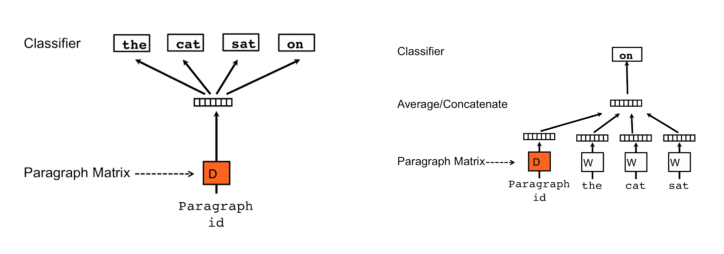

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
tagged_data = [TaggedDocument(words=word_tokenize(doc), tags=[i]) for i, doc in enumerate(documents_df['documents'])]

In [ ]:
model_d2v = Doc2Vec(vector_size=100,alpha=0.025, min_count=1)
  
model_d2v.build_vocab(tagged_data)

for epoch in range(100):
    model_d2v.train(tagged_data,
                total_examples=model_d2v.corpus_count,
                epochs=model_d2v.epochs)

In [ ]:
document_embeddings=np.zeros((documents_df.shape[0],100))

for i in range(len(document_embeddings)):
    document_embeddings[i]=model_d2v.docvecs[i]

In [ ]:
pairwise_similarities=cosine_similarity(document_embeddings)
pairwise_differences=euclidean_distances(document_embeddings)

In [ ]:
most_similar(0,pairwise_similarities,'Cosine Similarity')

In [ ]:
most_similar(0,pairwise_differences,'Euclidean Distance')

#### BERT model

BERT- Bidirectional Encoder Representation from Transformers (BERT) is a state of the art technique for natural language processing pre-training developed by Google. BERT is trained on unlabelled text including Wikipedia and Book corpus. BERT uses transformer architecture, an attention model to learn embeddings for words.

BERT consists of two pre training steps Masked Language Modelling (MLM) and Next Sentence Prediction (NSP). In BERT training text is represented using three embeddings, Token Embeddings + Segment Embeddings + Position Embeddings.

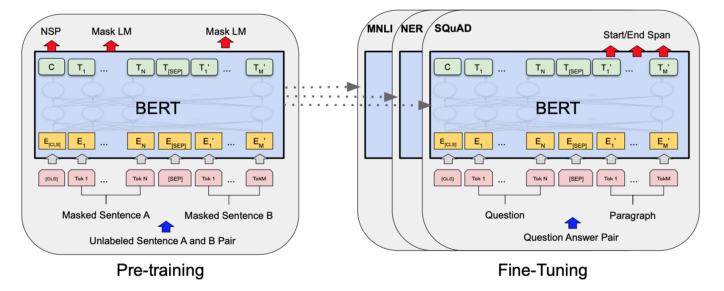

In [ ]:
# Install the library using pip
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

https://github.com/neuralmind-ai/portuguese-bert

# BERTimbau - Portuguese BERT



In [ ]:
from transformers import AutoModel, AutoTokenizer

sbert_model = SentenceTransformer('neuralmind/bert-base-portuguese-cased')

In [ ]:
document_embeddings = sbert_model.encode(documents_df['documents'])

In [ ]:
pairwise_similarities=cosine_similarity(document_embeddings)
pairwise_differences=euclidean_distances(document_embeddings)

In [ ]:
most_similar(0,pairwise_similarities,'Cosine Similarity')

In [ ]:
most_similar(0,pairwise_differences,'Euclidean Distance')

## Perform Semantic Search

In [ ]:
import scipy
#@title Sematic Search Form

# code adapted from https://github.com/UKPLab/sentence-transformers/blob/master/examples/application_semantic_search.py

query = 'meio ambiente' #@param {type: 'string'}

queries = [query]
query_embeddings = sbert_model.encode(queries)

# Find the closest 5 documents of the corpus for each query sentence based on cosine similarity
number_top_matches = 5 #@param {type: "number"}

print("Semantic Search Results")

for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], document_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar documents in corpus:")

    for idx, distance in results[0:number_top_matches]:
        print(documents_df['documents'][idx].strip(), "(Cosine Score: %.4f)" % (1-distance))